In [26]:
import xarray as xr
import numpy as np
from PIL import Image as PILImage
from osgeo import gdal, osr, gdal_array
import netCDF4
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyproj
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
import matplotlib.cm as cm

data=xr.open_dataset('./data/cloud3D_image.nc')
image = mpimg.imread('./data/PAN_reference.png')

import plotly
plotly.tools.set_credentials_file(username='mseymour24', api_key='dj5yHkhdjk9OXisXLJME')
import plotly.plotly as ply
import plotly.graph_objs as go

import shapely.geometry as geometry

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from matplotlib import colors

from descartes import PolygonPatch
def plot_polygon(ax,polygon):
    margin = .3
    x_min, y_min, x_max, y_max = polygon.bounds
    patch = PolygonPatch(polygon, fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
    ax.add_patch(patch)
    return fig

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [2]:
data

<xarray.Dataset>
Dimensions:            (i: 500, j: 500, x: 3, y: 500, z: 500)
Dimensions without coordinates: i, j, x, y, z
Data variables:
    band_0             (i, j) int32 ...
    nb_views           (i, j) int32 ...
    nodata             (i, j) int32 ...
    radius             (i, j) float32 ...
    secondary_1        (i, j) int32 ...
    secondary_2        (i, j) int32 ...
    dir_view_1_vector  (x, y, z) int32 ...
    dir_view_1_origin  (x, y, z) int32 ...
    dir_view_2_vector  (x, y, z) int32 ...
    dir_view_2_origin  (x, y, z) int32 ...
    dir_view_3_vector  (x, y, z) int32 ...
    dir_view_3_origin  (x, y, z) int32 ...
    coord_ECEF         (x, y, z) float64 ...

In [3]:
#Extraction de la donnée
cloud3D = np.array(data.coord_ECEF)
x = cloud3D[0]
y = cloud3D[1]
z = cloud3D[2]
nb_views=data.nb_views.to_pandas()
nb_views = np.array(nb_views)

#Classification SVM
SVM = gdal.Open('./data/clLabeledImage_SVM.tif')
classe = SVM.GetRasterBand(1).ReadAsArray()
classe = np.array(classe)
print (np.min(classe),np.max(classe))
#Projection sur ROI
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='utm', ellps='WGS84', datum='WGS84')
p = pyproj.transform(ecef, lla, x, y, z, radians=True)

2 4


In [78]:
#Parametres Region considérés et altitude du plan de coupe pour la segmentation
start_x,start_y,w,h=0,0,500,500

#Region considérée en LLA (projection)
px =np.array([p[0][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
py = np.array([p[1][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
pz = np.array([p[2][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
pclasse=np.array([classe[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
pzmin=np.quantile(pz.flatten(),0.75)
#Segmentation des batiments en ECEF
segmbatx =np.array([x[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin<=p[2][i,j])])
segmbaty = np.array([y[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin<=p[2][i,j])])
segmbatz = np.array([z[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin<=p[2][i,j])])
#Seegmentation du sol en ECEF
segm1x =np.array([x[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin>p[2][i,j])])
segm1y = np.array([y[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin>p[2][i,j])])
segm1z = np.array([z[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin>p[2][i,j])])
#Region considérée en ECEF
ecfx =np.array([x[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
ecfy = np.array([y[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
ecfz = np.array([z[i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0)])
#Segmentation des batiments en LLA
segmbatpx =np.array([p[0][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin<=p[2][i,j])])
segmbatpy = np.array([p[1][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin<=p[2][i,j])])
segmbatpz = np.array([p[2][i,j] for i in range(start_x,start_x+w) for j in range(start_y,start_y+h) if (x[i,j]!=0 and y[i,j]!=0 and z[i,j]!=0 and pzmin<=p[2][i,j])])


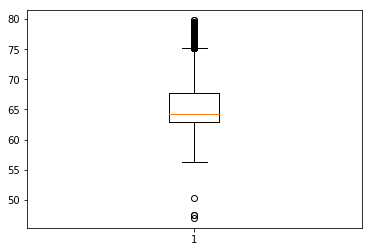

In [79]:
plt.boxplot(pz.flatten())
plt.show()

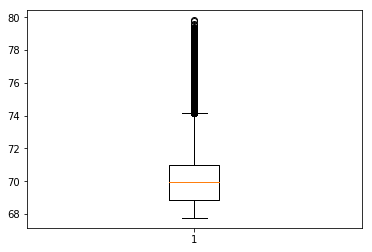

In [80]:
plt.boxplot(pz.flatten()[pz.flatten()>=np.quantile(pz.flatten(),0.75)])
plt.show()

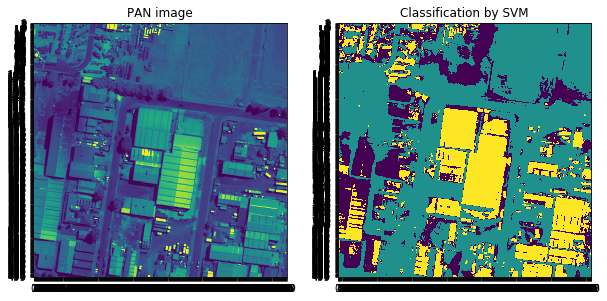

In [81]:
gs=GridSpec(1,2)
fig=plt.figure(figsize=(10,5))
ax0 = fig.add_subplot(gs[0,0])
plt.title('PAN image')
plt.xticks(range(start_x,start_x+w))
plt.yticks(range(start_y,start_y+h))
plt.imshow(image[start_x:start_x+w,start_y:start_y+h])

ax1 = fig.add_subplot(gs[0,1])
plt.title('Classification by SVM')
plt.xticks(range(start_x,start_x+w))
plt.yticks(range(start_y,start_y+h))
plt.imshow(classe[start_x:start_x+w,start_y:start_y+h])
plt.show()

In [82]:
#Parameters
threshold=50
epsilon = 1 / 25

In [83]:
coords=np.concatenate(([segmbatpx],[segmbatpy])).T
#DBSCAN
db = DBSCAN(eps=epsilon, min_samples=1).fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
len_clusters=np.array([len(np.where(cluster_labels==i)[0]) for i in range(num_clusters)])
i_clusters=np.where(len_clusters>=threshold)[0]
num_clusters_cleaned=len(i_clusters)
coords_clusters=[coords[np.where(i==cluster_labels)[0]] for i in i_clusters]

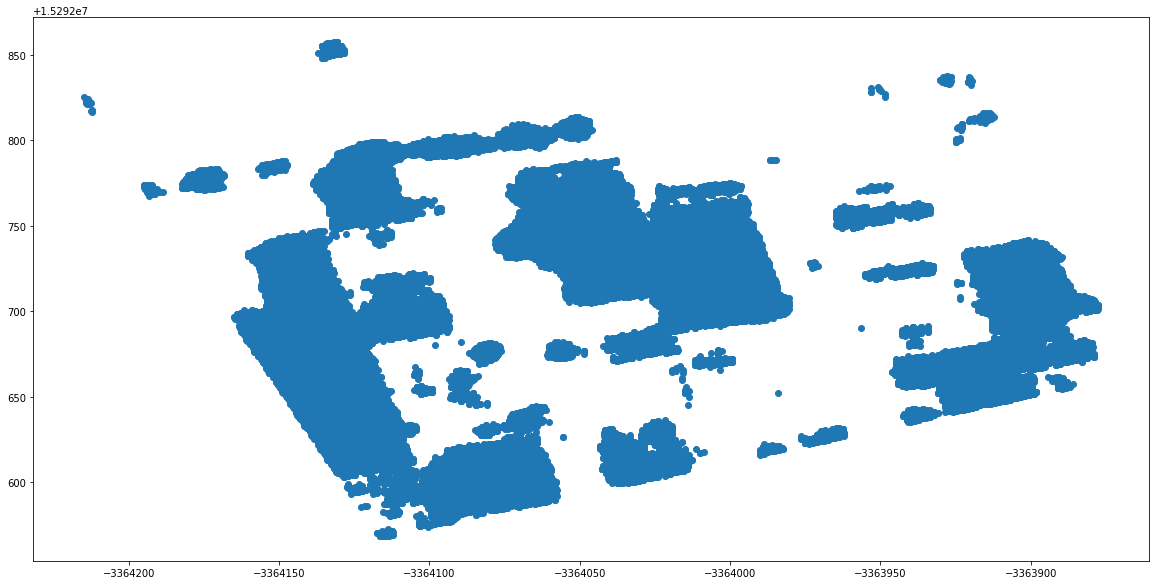

In [87]:
plt.figure(figsize=(20,10))
plt.plot(-segmbatpx,-segmbatpy,'o')
plt.show()

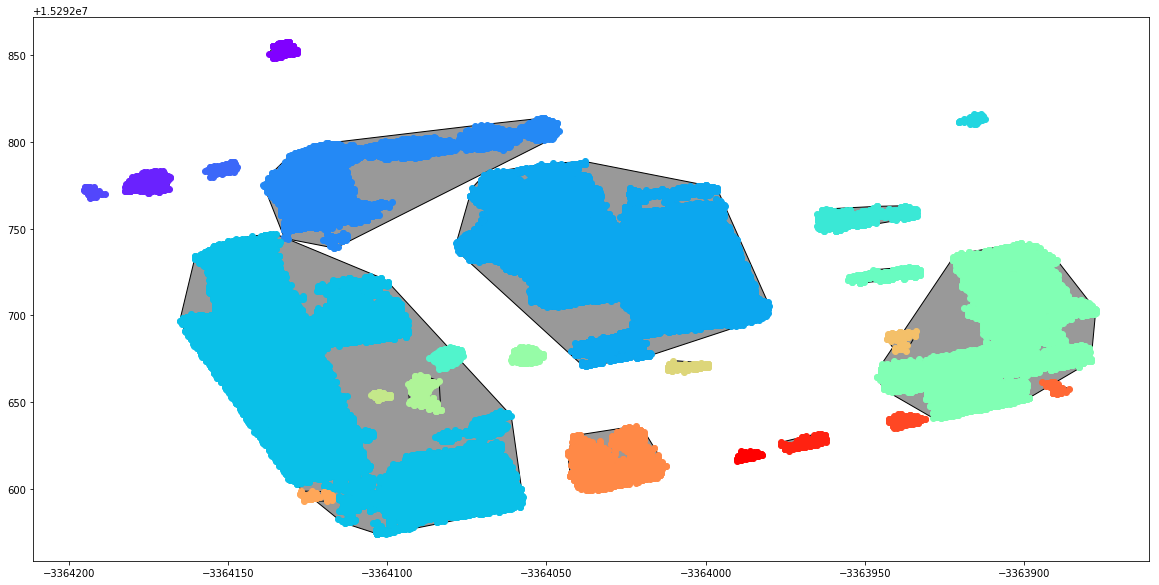

In [88]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
for i in range(num_clusters_cleaned):
    plt.scatter(-coords_clusters[i][:,0],-coords_clusters[i][:,1],color=colors[i])
    point_collection = geometry.MultiPoint(list(-coords_clusters[i]))
    plot_polygon(ax,point_collection.convex_hull)
plt.show()

In [401]:
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
from shapely.geometry import MultiPoint
from shapely.ops import triangulate
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges,edge_points, coords, pi, pj):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
    """
        #if (pi, pj) in edges or (pj, pi) in edges:
            # already added
        #    return
        #edges.add( (pi, pj) )
        edge_points.append( [pi, pj] )
    multi_points=MultiPoint(points)
    triangles = triangulate(multi_points)
    tri = [np.array(triangle.exterior.coords.xy)[:,:3].T for triangle in triangles]
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for pa, pb, pc in tri:
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, pa, pb)
            add_edge(edges, edge_points, coords, pb, pc)
            add_edge(edges, edge_points, coords, pc, pa)
    m = geometry.MultiLineString(edge_points)
    new_triangles = list(polygonize(m))
    return cascaded_union(new_triangles), edge_points

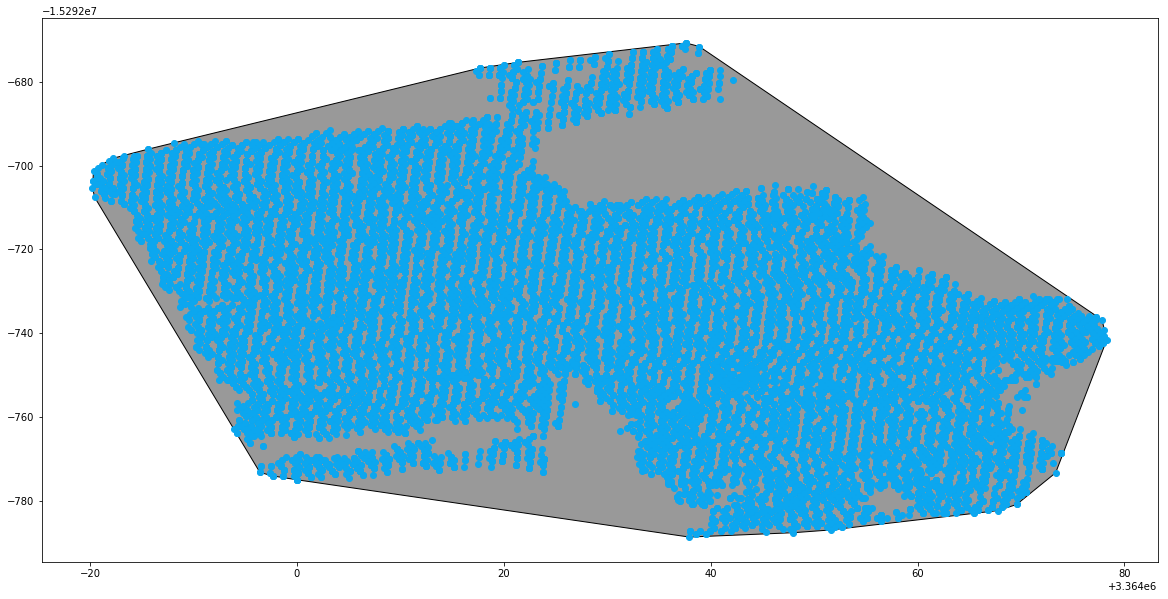

In [214]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
i=5
plt.scatter(coords_clusters[i][:,0],coords_clusters[i][:,1],color=colors[i])
point_collection = geometry.MultiPoint(list(coords_clusters[i]))
plot_polygon(ax,point_collection.convex_hull)
plt.show()

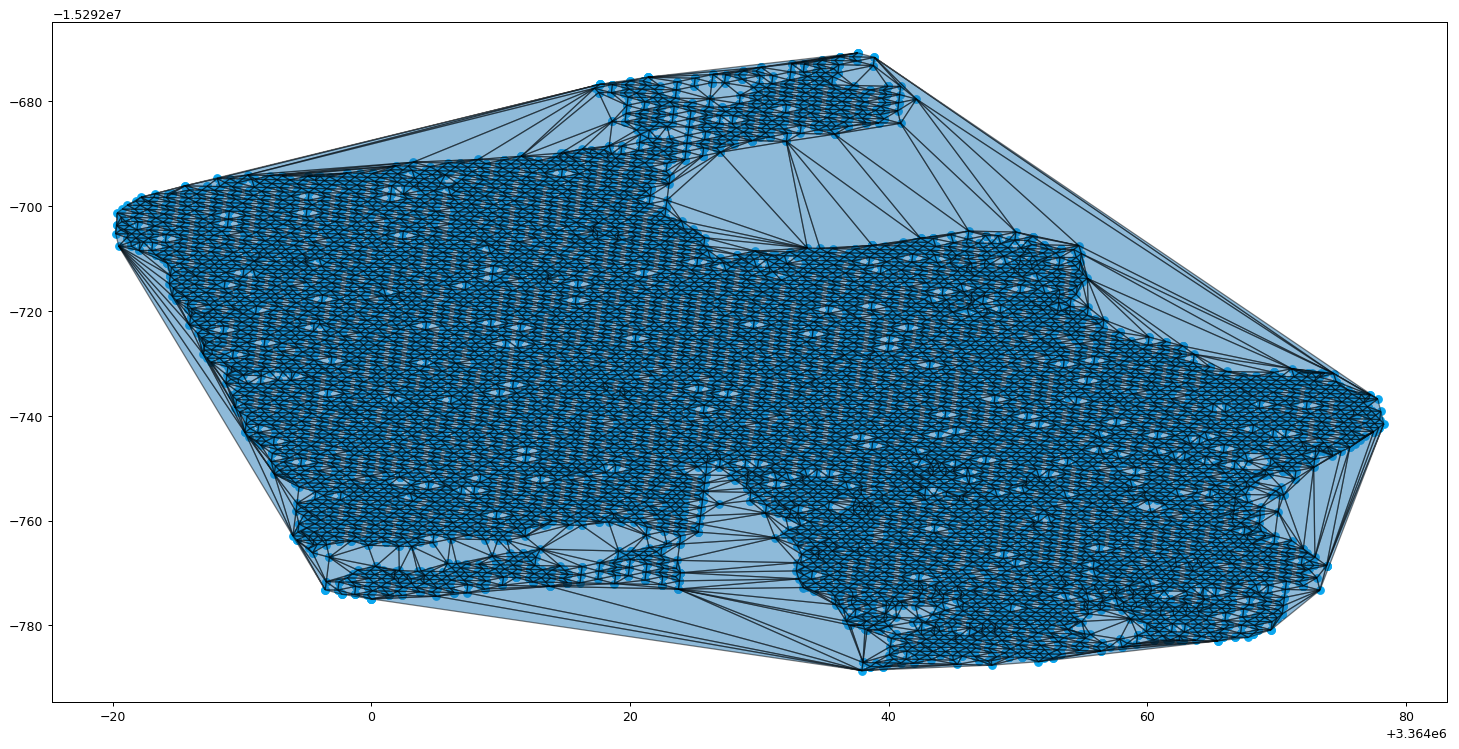

In [278]:
i=5
new_points=coords_clusters[i]
multi_points=MultiPoint(new_points)
triangles = Delaunay(multi_points)

fig = plt.figure(1, figsize=(20,10), dpi=90)
fig.set_frameon(True)
ax = fig.add_subplot(111)

for triangle in triangles:
    patch = PolygonPatch(triangle, alpha=0.5, zorder=2)
    ax.add_patch(patch)

plt.scatter(new_points[:,0],new_points[:,1],color=colors[i])
    
plt.show()

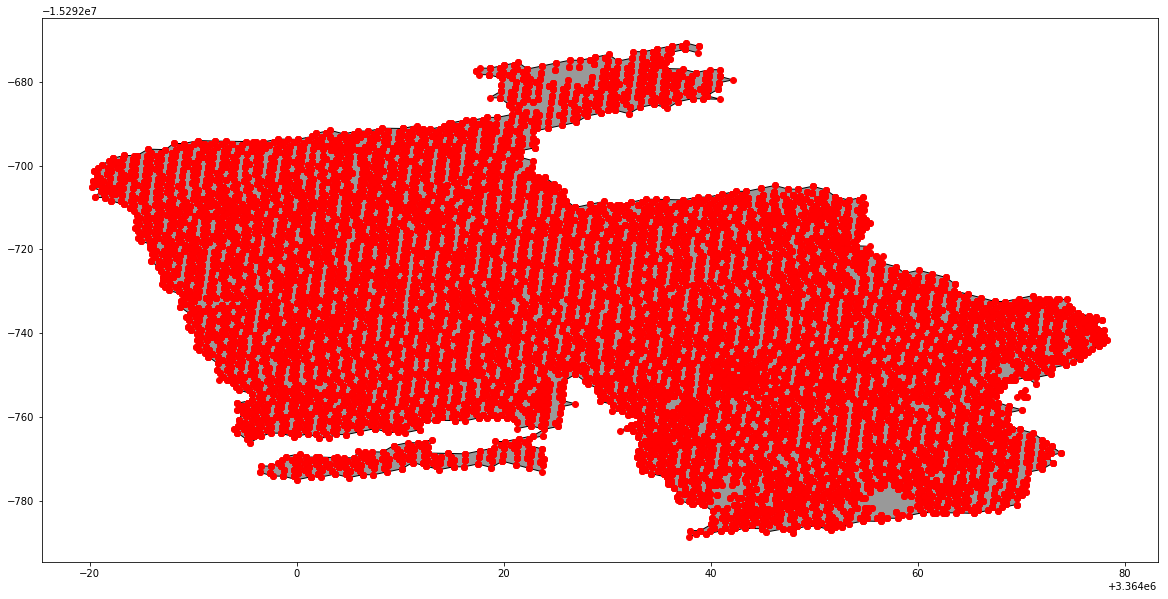

In [402]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
new_points=coords_clusters[i]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
i=5
concave_hull, edge_points = alpha_shape(new_points,alpha=1)
plot_polygon(ax,concave_hull)
#plt.plot(new_points[:,0],new_points[:,1],'o')
plt.plot(np.array(edge_points)[:,0][:,0],np.array(edge_points)[:,0][:,1],'or')
plt.show()

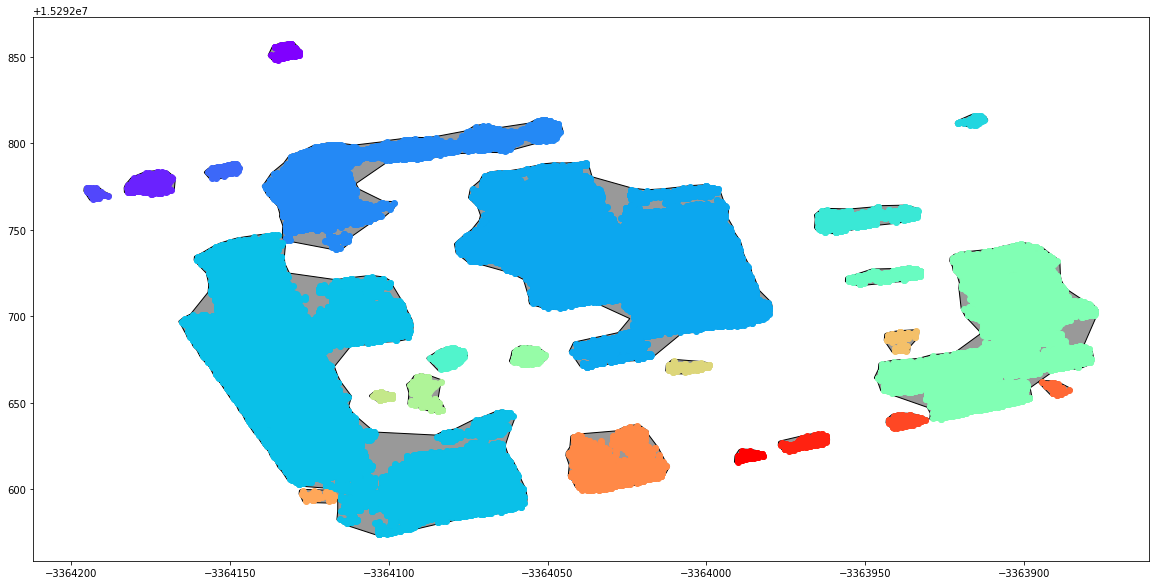

In [414]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Polygons=[]
for i in range(num_clusters_cleaned):
    plt.scatter(-coords_clusters[i][:,0],-coords_clusters[i][:,1],color=colors[i])
    concave_hull, edge_points = alpha_shape(-coords_clusters[i],alpha=0.1)
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    #plt.plot(polygon_coords[:,0],polygon_coords[:,1],'or')
    Polygons.append(polygon_coords)
    plot_polygon(ax,concave_hull.buffer(1))
plt.show()

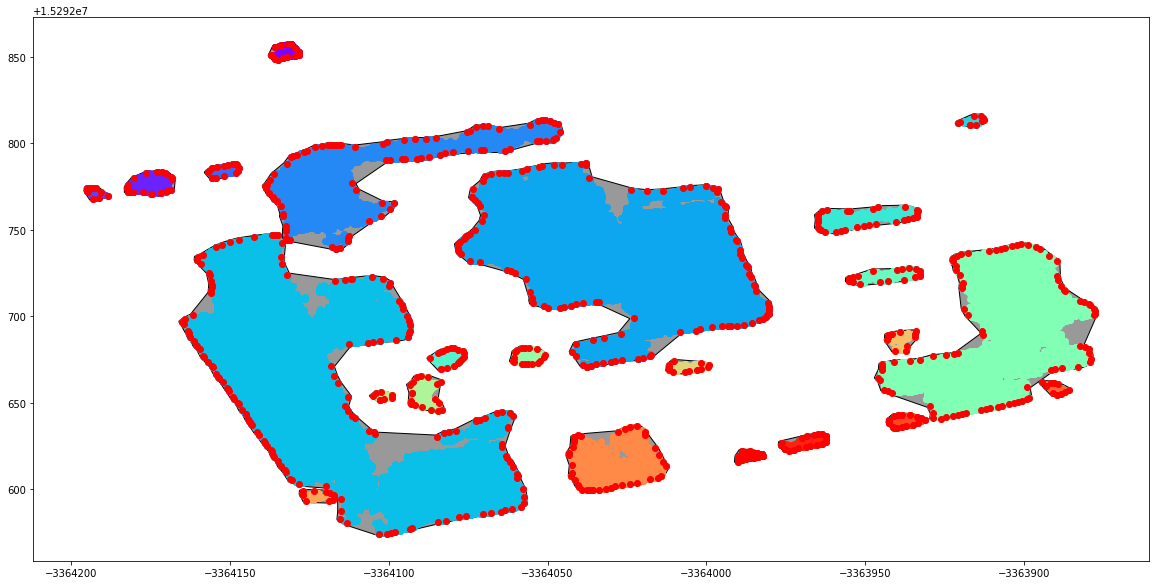

In [413]:
colors=cm.rainbow(np.linspace(0, 1, num_clusters_cleaned))
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
Polygons=[]
for i in range(num_clusters_cleaned):
    plt.scatter(-coords_clusters[i][:,0],-coords_clusters[i][:,1],color=colors[i])
    concave_hull, edge_points = alpha_shape(-coords_clusters[i],alpha=0.1)
    polygon_coords=np.array(concave_hull.exterior.coords.xy)[:,:].T
    plt.plot(polygon_coords[:,0],polygon_coords[:,1],'or')
    Polygons.append(polygon_coords)
    plot_polygon(ax,concave_hull.buffer(1))
plt.show()

In [412]:
concave_hull.exterior.xy

(array('d', [-3363990.0366350743, -3363989.956196813, -3363988.8146598064, -3363986.1462359824, -3363983.8715835917, -3363982.577591377, -3363982.264259295, -3363983.638689717, -3363985.0131203104, -3363987.3682110757, -3363988.74264204, -3363990.1170731764, -3363990.0366350743]),
 array('d', [15292617.534028564, 15292619.090302784, 15292622.164205898, 15292622.017068824, 15292621.126718275, 15292620.27501314, 15292619.461953416, 15292618.757384883, 15292618.05281618, 15292617.386892555, 15292616.682323521, 15292615.97775431, 15292617.534028564]))